In [1]:
from keras import models
from keras import layers
import pandas as pd
import numpy as np
import datetime as DT
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
#Load Monroe vote history data
Monroe = pd.read_table("/Users/isaac/Dropbox (UFL)/DeepLearning_Voter_Turnout/20180109_VoterHistory/MON_H_20180109.txt",header=None, sep = "\t", low_memory=False)
Monroe.columns = ["County Code", "VoterID", "Election_Date", "Election Type", "History Code"]


##Load party registration data
Monroe_reg = pd.read_table("/Users/isaac/Dropbox (UFL)/DeepLearning_Voter_Turnout/20180109_VoterDetail/MON_20180109.txt",header=None, sep = "\t", low_memory=False)
Monroe_reg.columns = ["CountyCode", "VoterID", "NameLast", "NameSuffix", "NameFirst", "NameMiddle", "Requestedpublicrecordsexemption", "ResidenceAddressLine1", "ResidenceAddressLine2", "ResidenceCity(USPS)", "ResidenceState", "ResidenceZipcode", "MailingAddressLine1", "MailingAddressLine2", "MailingAddressLine3", "MailingCity", "MailingState", "MailingZipcode", "MailingCountry", "Gender", "Race", "BirthDate", "RegistrationDate", "PartyAffiliation", "Precinct", "PrecinctGroup", "PrecinctSplit", "PrecinctSuffix", "VoterStatus", "CongressionalDistrict", "HouseDistrict", "SenateDistrict", "CountyCommissionDistri", "SchoolBoardDistrict", "DaytimeAreaCode", "DaytimePhoneNumber", "DaytimePhoneExtension", "Emailaddress"]
imp_cols = [0, 1, 11, 19, 20,21,22,23,24,28,29,30,31,32,33]
Monroe_reg_red = Monroe_reg.iloc[:,imp_cols]

##Merge - Monroe
monroe_merge = Monroe_reg_red.merge(Monroe, how="left", on = "VoterID")
monroe_merge["Election_Date"] = pd.to_datetime(monroe_merge["Election_Date"])
monroe_merge = monroe_merge.sort_values("Election_Date")
monroe_merge["count"] = 1

#Convert to wide data
wide_data = monroe_merge.pivot_table(index='VoterID',columns='Election_Date',values='count', aggfunc= "max")
wide_data.shape
wide_data.columns = wide_data.columns.map(lambda t: t.strftime('%Y-%m'))
wide_data[wide_data.isnull()] =0
wide_data_demos = wide_data.merge(Monroe_reg_red, how="left",left_index=True, right_on = "VoterID")


In [13]:
#Format training data
now = pd.Timestamp(DT.datetime.now())
train_data = wide_data_demos.drop(['2010-11', '2014-11','2015-10', '2015-11', '2016-03','2016-08', '2016-11', '2017-03', 'VoterID', 'CountyCode'], axis=1)
train_data['Age'] = (now - pd.to_datetime(wide_data_demos['BirthDate'])).astype('<m8[Y]')  
train_data['Years_reg'] = (now - pd.to_datetime(wide_data_demos['RegistrationDate'])).astype('<m8[Y]')  
train_data = train_data.drop(['RegistrationDate', 'BirthDate'], axis = 1)
train_data.iloc[:,31:42] = train_data.iloc[:,31:42].apply(lambda x: pd.factorize(x)[0])

#Training and test elections
train_election = wide_data_demos['2010-11']
test_election = wide_data_demos['2014-11']

#Reduced data
red_train_data = train_data.iloc[:,0:37]
red_train_data['Gender'] = train_data['Gender']
red_train_data['PartyAffiliation'] = train_data['PartyAffiliation']
red_train_data['VoterStatus'] = train_data['VoterStatus']

red_train_data['Years_reg'] =  train_data['Years_reg']/ np.max(train_data['Years_reg'])

In [4]:
#Set up and fit the model
network = models.Sequential()
network.add(layers.Dense(38, activation='relu', input_shape=(red_train_data.shape[1],)))
network.add(layers.Dense(38, activation='relu'))
network.add(layers.Dense(20, activation='relu'))
network.add(layers.Dense(20, activation='relu'))
network.add(layers.Dense(10, activation='relu'))
network.add(layers.Dense(10, activation='relu'))
network.add(layers.Dense(5, activation='relu'))
network.add(layers.Dense(5, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))


network.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['acc'])


network.fit(red_train_data,train_election, epochs=20, batch_size=80)




Epoch 1/20
49233/49233 [==============================] - 9s 178us/step - loss: 0.5295 - acc: 0.8283
Epoch 2/20
49233/49233 [==============================] - 6s 129us/step - loss: 0.4201 - acc: 0.8654
Epoch 3/20
49233/49233 [==============================] - 7s 143us/step - loss: 0.3726 - acc: 0.8685
Epoch 4/20
49233/49233 [==============================] - 7s 140us/step - loss: 0.3441 - acc: 0.8689
Epoch 5/20
49233/49233 [==============================] - 7s 138us/step - loss: 0.3264 - acc: 0.8703
Epoch 6/20
49233/49233 [==============================] - 7s 140us/step - loss: 0.3163 - acc: 0.8709
Epoch 7/20
49233/49233 [==============================] - 8s 155us/step - loss: 0.3096 - acc: 0.8702
Epoch 8/20
49233/49233 [==============================] - 7s 140us/step - loss: 0.3030 - acc: 0.8724
Epoch 9/20
49233/49233 [==============================] - 7s 139us/step - loss: 0.2992 - acc: 0.8713
Epoch 10/20
49233/49233 [==============================] - 7s 149us/step - loss: 0.2963 - a

In [7]:
#Accuracy on test set
network.evaluate(red_train_data, test_election)



49233/49233 [==============================] - 3s 64us/step


[0.7107338336103864, 0.7423476123738143]

In [8]:
preds = network.predict(red_train_data)
for x in np.arange(.1,1, .1):
    print(np.mean(test_election.iloc[(preds > x).flatten().tolist()] == 1))
#    print(np.mean(test_election.iloc[(preds > x).flatten().tolist()] == 0))

0.7075384772890148
0.7475314005845644
0.766703130259172
0.8034872761545712
0.8361943711994834
0.857748075660839
0.8799972850064481
0.9041248606465998
0.9338860103626943


In [12]:
#Total votes in 2014 and in selected subset
print(np.sum(test_election))
print(np.sum(test_election.iloc[(preds > .7).flatten().tolist()]))

#Percent voted in selected subset
print(np.mean(test_election.iloc[(preds > .7).flatten().tolist()] == 1))

25180.0
12965.0
0.8799972850064481


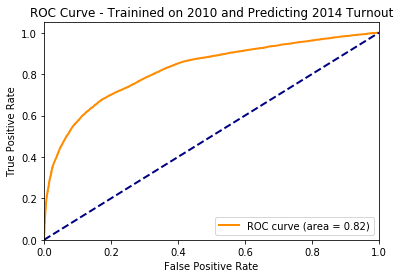

In [6]:
##ROC curve
fpr, tpr, _ = roc_curve(test_election, preds)
roc_auc = auc(fpr, tpr)
# Compute micro-average ROC curve and ROC area

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Trainined on 2010 and Predicting 2014 Turnout')
plt.legend(loc="lower right")
plt.show()